[GLUE benchmark의 한국어 버전 KLUE benchmark](https://klue-benchmark.com/)

model(klue/ber-base)를 활용하여 NSMC(Naver Sentiment Movie Corpus) task 진행

모델 : [KLUE/Bert-base](https://huggingface.co/klue/bert-base)  
데이터셋 : [NSMC](https://github.com/e9t/nsmc)  


### Huggingface transformers 설치 및 환경 구성
$ python -c "from transformers import pipeline; print(pipeline('sentiment-analysis')('I love you'))"

위의 코드가 잘 실행되지 않을 경우 터미널을 열고 아래 명령어를 입력하여 환경을 구성합니다.
$ pip uninstall transformers -y  

$ pip install transformers  

$ mkdir -p transformers

In [1]:
import tensorflow
import numpy
import transformers
import datasets

print(tensorflow.__version__)
print(numpy.__version__)
print(transformers.__version__)
print(datasets.__version__)

2.6.0
1.21.4
4.11.3
1.14.0


# NSMC 데이터 분석 및 Huggingface dataset 구성

In [2]:
import datasets
from datasets import load_dataset #  Hugging Face 라이브러리의 함수

huggingface_nsmc_dataset = load_dataset('nsmc')

Using custom data configuration default
Reusing dataset nsmc (/aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3)


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
print(huggingface_nsmc_dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 50000
    })
})


In [4]:
train = huggingface_nsmc_dataset['train']
cols = train.features
cols

{'id': Value(dtype='string', id=None),
 'document': Value(dtype='string', id=None),
 'label': ClassLabel(num_classes=2, names=['negative', 'positive'], names_file=None, id=None)}

In [5]:
for i in range(5):
    for col_name, col_data in train[i].items():
        print(col_name, ":", col_data)
    print('\n')

label : 0
document : 아 더빙.. 진짜 짜증나네요 목소리
id : 9976970


label : 1
document : 흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
id : 3819312


label : 0
document : 너무재밓었다그래서보는것을추천한다
id : 10265843


label : 0
document : 교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
id : 9045019


label : 1
document : 사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다
id : 6483659




In [6]:
import pandas as pd

# 데이터셋을 pandas DataFrame으로 변환
df = pd.DataFrame(train[:5])

# DataFrame 출력
df

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# klue/bert-base model 및 tokenizer 불러오기

In [7]:
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification

huggingface_tokenizer = AutoTokenizer.from_pretrained('klue/bert-base')
huggingface_model = AutoModelForSequenceClassification.from_pretrained('klue/bert-base', num_labels=2)

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized

In [8]:
# 토크나이징
def transform(data):
    return huggingface_tokenizer(
    data['document'],
    truncation = True, # 문장 길이 조정
    padding = 'max_length',
        return_token_type_ids = False,
    )

In [9]:
hf_dataset = huggingface_nsmc_dataset.map(transform, batched = True)

# train, test
original_hf_train = hf_dataset['train']
hf_test = hf_dataset['test']

Loading cached processed dataset at /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-522b4d629f2b3643.arrow
Loading cached processed dataset at /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-c93bfbbf5a65bda7.arrow


In [10]:
hf_dataset

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'document', 'id', 'input_ids', 'label'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['attention_mask', 'document', 'id', 'input_ids', 'label'],
        num_rows: 50000
    })
})

In [12]:
# 원하는 데이터 크기
desired_dataset_size = 15000  # 원하는 데이터셋 크기로 수정

# 원하는 크기에 해당하는 데이터만 선택
reduced_dataset = original_hf_train.select(range(desired_dataset_size))

# 학습에 사용할 데이터셋
hf_dataset['train'] = reduced_dataset

In [13]:
hf_train_datasets = hf_dataset['train'].train_test_split(test_size=0.3) # huggingface train_test_split
hf_train_datasets

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'document', 'id', 'input_ids', 'label'],
        num_rows: 10500
    })
    test: Dataset({
        features: ['attention_mask', 'document', 'id', 'input_ids', 'label'],
        num_rows: 4500
    })
})

In [14]:
hf_train_dataset = hf_train_datasets['train']
hf_val_dataset = hf_train_datasets['test']

#  tokenizer으로 데이터셋을 전처리하고, model 학습 진행

In [15]:
import os
from transformers import Trainer, TrainingArguments

output_dir = '/aiffel/aiffel/DeepGoing_NLP'

training_argument = TrainingArguments(
    output_dir, # output 저장될 경로
    evaluation_strategy = 'epoch', # 평가하는 빈도
    learning_rate = 2e-5, 
    per_device_train_batch_size = 8, # 각 device 당 batch size
    per_device_eval_batch_size = 8, # evaluation 시에 batch size
    num_train_epochs = 3,
    weight_decay = 0.01
)

In [16]:
from datasets import load_metric
import numpy as np
metric = load_metric('accuracy')

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis = 1)
    return metric.compute(predictions=predictions, references = labels)

In [28]:
trainer = Trainer(
    model = huggingface_model, # 학습시킬 모델
    args = training_argument, # training_argument
    train_dataset = hf_train_dataset, # train_dataset
    eval_dataset = hf_val_dataset,
    compute_metrics = compute_metrics,
)

In [29]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, id.
***** Running training *****
  Num examples = 10500
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3939


Epoch,Training Loss,Validation Loss,Accuracy
1,0.164600,0.583884,0.870667
2,0.170700,0.608780,0.876667
3,0.068300,0.731153,0.876444


Saving model checkpoint to /aiffel/aiffel/DeepGoing_NLP/checkpoint-500
Configuration saved in /aiffel/aiffel/DeepGoing_NLP/checkpoint-500/config.json
Model weights saved in /aiffel/aiffel/DeepGoing_NLP/checkpoint-500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/DeepGoing_NLP/checkpoint-1000
Configuration saved in /aiffel/aiffel/DeepGoing_NLP/checkpoint-1000/config.json
Model weights saved in /aiffel/aiffel/DeepGoing_NLP/checkpoint-1000/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, id.
***** Running Evaluation *****
  Num examples = 4500
  Batch size = 8
Saving model checkpoint to /aiffel/aiffel/DeepGoing_NLP/checkpoint-1500
Configuration saved in /aiffel/aiffel/DeepGoing_NLP/checkpoint-1500/config.json
Model weights saved in /aiffel/aiffel/DeepGoing_NLP/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/DeepGoing_NLP/ch

TrainOutput(global_step=3939, training_loss=0.135897266710431, metrics={'train_runtime': 3613.4711, 'train_samples_per_second': 8.717, 'train_steps_per_second': 1.09, 'total_flos': 8287998243840000.0, 'train_loss': 0.135897266710431, 'epoch': 3.0})

In [30]:
eval_metrics = trainer.evaluate(hf_test)
print(eval_metrics)

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, id.
***** Running Evaluation *****
  Num examples = 50000
  Batch size = 8


{'eval_loss': 0.7565054893493652, 'eval_accuracy': 0.87308, 'eval_runtime': 1852.7813, 'eval_samples_per_second': 26.986, 'eval_steps_per_second': 3.373, 'epoch': 3.0}


In [31]:
del huggingface_model

# Fine-tuning을 통하여 모델 성능(accuarcy) 향상시키기

In [17]:
huggingface_model = AutoModelForSequenceClassification.from_pretrained('klue/bert-base', num_labels=2)

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized

In [18]:
training_argument = TrainingArguments(
    output_dir, # output 저장될 경로
    evaluation_strategy = 'epoch', # 평가하는 빈도
    learning_rate = 5e-5, 
    per_device_train_batch_size = 8, # 각 device 당 batch size
    per_device_eval_batch_size = 8, # evaluation 시에 batch size
    num_train_epochs = 3,
    weight_decay = 0.01
)

In [19]:
trainer = Trainer(
    model = huggingface_model, # 학습시킬 모델
    args = training_argument, # training_argument
    train_dataset = hf_train_dataset, # train_dataset
    eval_dataset = hf_val_dataset,
    compute_metrics = compute_metrics,
)

In [20]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, id.
***** Running training *****
  Num examples = 10500
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3939


Epoch,Training Loss,Validation Loss,Accuracy
1,0.404900,0.362438,0.863111
2,0.272000,0.452394,0.868000
3,0.130200,0.603608,0.874444


Saving model checkpoint to /aiffel/aiffel/DeepGoing_NLP/checkpoint-500
Configuration saved in /aiffel/aiffel/DeepGoing_NLP/checkpoint-500/config.json
Model weights saved in /aiffel/aiffel/DeepGoing_NLP/checkpoint-500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/DeepGoing_NLP/checkpoint-1000
Configuration saved in /aiffel/aiffel/DeepGoing_NLP/checkpoint-1000/config.json
Model weights saved in /aiffel/aiffel/DeepGoing_NLP/checkpoint-1000/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, id.
***** Running Evaluation *****
  Num examples = 4500
  Batch size = 8
Saving model checkpoint to /aiffel/aiffel/DeepGoing_NLP/checkpoint-1500
Configuration saved in /aiffel/aiffel/DeepGoing_NLP/checkpoint-1500/config.json
Model weights saved in /aiffel/aiffel/DeepGoing_NLP/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/DeepGoing_NLP/ch

TrainOutput(global_step=3939, training_loss=0.2788356113748582, metrics={'train_runtime': 3678.2123, 'train_samples_per_second': 8.564, 'train_steps_per_second': 1.071, 'total_flos': 8287998243840000.0, 'train_loss': 0.2788356113748582, 'epoch': 3.0})

In [21]:
eval_metrics = trainer.evaluate(hf_test)
print(eval_metrics)

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, id.
***** Running Evaluation *****
  Num examples = 50000
  Batch size = 8


{'eval_loss': 0.6371132731437683, 'eval_accuracy': 0.8694, 'eval_runtime': 1850.8266, 'eval_samples_per_second': 27.015, 'eval_steps_per_second': 3.377, 'epoch': 3.0}


In [22]:
del huggingface_model

# Bucketing을 적용하여 학습
[Data Collator](https://huggingface.co/docs/transformers/v4.30.0/en/main_classes/data_collator)

[Trainer.TrainingArguments 의 group_by_length](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments)

STEP 4에 학습한 결과와 bucketing을 적용하여 학습시킨 결과를 비교해보고, 모델 성능 향상과 훈련 시간 두 가지 측면에서 각각 어떤 이점이 있는지 비교해봅시다.

In [33]:
huggingface_tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")
huggingface_model = AutoModelForSequenceClassification.from_pretrained('klue/bert-base', num_labels=2)

loading configuration file https://huggingface.co/klue/bert-base/resolve/main/config.json from cache at /aiffel/.cache/huggingface/transformers/fbd0b2ef898c4653902683fea8cc0dd99bf43f0e082645b913cda3b92429d1bb.99b3298ed554f2ad731c27cdb11a6215f39b90bc845ff5ce709bb4e74ba45621
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32000
}

loading file https://huggingface.co/klue/bert-base/resolve/main/vocab.txt from cache at /aiffel/.cache/huggingface/transformers/1a36e69d48a0

In [34]:
training_argument = TrainingArguments(
    output_dir, # output 저장될 경로
    evaluation_strategy = 'epoch', # 평가하는 빈도
    learning_rate = 2e-5, 
    per_device_train_batch_size = 8, # 각 device 당 batch size
    per_device_eval_batch_size = 8, # evaluation 시에 batch size
    num_train_epochs = 3,
    weight_decay = 0.01, 
    group_by_length = True
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [38]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=huggingface_tokenizer)

In [39]:
trainer = Trainer(
    model = huggingface_model, # 학습시킬 모델
    args = training_argument, # training_argument
    data_collator=data_collator, # DataCollatorForLanguageModeling
    train_dataset = hf_train_dataset, # train_dataset
    eval_dataset = hf_val_dataset,
    compute_metrics = compute_metrics,
)

In [40]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, id.
***** Running training *****
  Num examples = 10500
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3939


Epoch,Training Loss,Validation Loss,Accuracy
1,0.370100,0.324814,0.871111
2,0.253600,0.459641,0.877778
3,0.144200,0.588307,0.878222


Saving model checkpoint to /aiffel/aiffel/DeepGoing_NLP/checkpoint-500
Configuration saved in /aiffel/aiffel/DeepGoing_NLP/checkpoint-500/config.json
Model weights saved in /aiffel/aiffel/DeepGoing_NLP/checkpoint-500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/DeepGoing_NLP/checkpoint-1000
Configuration saved in /aiffel/aiffel/DeepGoing_NLP/checkpoint-1000/config.json
Model weights saved in /aiffel/aiffel/DeepGoing_NLP/checkpoint-1000/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, id.
***** Running Evaluation *****
  Num examples = 4500
  Batch size = 8
Saving model checkpoint to /aiffel/aiffel/DeepGoing_NLP/checkpoint-1500
Configuration saved in /aiffel/aiffel/DeepGoing_NLP/checkpoint-1500/config.json
Model weights saved in /aiffel/aiffel/DeepGoing_NLP/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/DeepGoing_NLP/ch

TrainOutput(global_step=3939, training_loss=0.26408320763716997, metrics={'train_runtime': 3683.5687, 'train_samples_per_second': 8.551, 'train_steps_per_second': 1.069, 'total_flos': 8287998243840000.0, 'train_loss': 0.26408320763716997, 'epoch': 3.0})

In [41]:
eval_metrics = trainer.evaluate(hf_test)
print(eval_metrics)

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, id.
***** Running Evaluation *****
  Num examples = 50000
  Batch size = 8


{'eval_loss': 0.58770352602005, 'eval_accuracy': 0.87628, 'eval_runtime': 1849.559, 'eval_samples_per_second': 27.033, 'eval_steps_per_second': 3.379, 'epoch': 3.0}


In [ ]:
del huggingface_model

# 회고
- DataCollatorForLanguageModeling과 group_by_length = True를 설정하면서 huggingface 공식 홈페이지와 친해져야겠다는 것을 느꼈다
- cuda out of memory 로 인해 데이터를 1/10로 줄여서 학습을 진행했더니 학습시에 Validation Loss가 증가해서 과적합이 일어난 것 같다. 
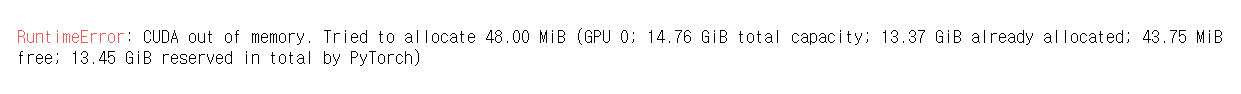